## Imports

In [ ]:
!pip install Unidecode
!pip install imbalanced-learn
#from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
import numpy as np
from numpy import hstack
from numpy import vstack
from numpy import asarray
import matplotlib.pyplot as plt
import seaborn as sns
import unidecode
import pickle
#import umap
import re
import string
from string import punctuation
#from gensim.models import Word2Vec
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,\
                         ShuffleSplit,StratifiedShuffleSplit, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from mlxtend.classifier import EnsembleVoteClassifier
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('rslp')

     |████████████████████████████████| 245kB 5.0MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path_modelos = '/content/drive/My Drive/Residencia/dev/Modelos_Treinamento/'
path_modelos2 = '/content/drive/My Drive/Residencia/dev/Modelos_Treinados/'
path_dev = '/content/drive/My Drive/Residencia/dev/'

Mounted at /content/drive


In [ ]:
#https://fasttext.cc/docs/en/support.html
'''
!pip install fasttext
import fasttext
import fasttext.util
fasttext.util.download_model('pt')
ft = fasttext.load_model('cc.pt.300.bin')'''

"\n!pip install fasttext\nimport fasttext\nimport fasttext.util\nfasttext.util.download_model('pt')\nft = fasttext.load_model('cc.pt.300.bin')"

In [ ]:
#http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc
'''!pip install gensim==2.0.0
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format(‘model.txt’)'''

'!pip install gensim==2.0.0\nfrom gensim.models import KeyedVectors\nmodel = KeyedVectors.load_word2vec_format(‘model.txt’)'

## Funções e constantes

In [ ]:
lista_lt = ['li','lr','lit','litro', 'litros', 'ltr', 'l','lt', 'lts','ltrs']
lista_kg = ['kg','kgs','quilo','quilos','kilos','kilos','kl','kgas','kga','kg1', 'kg3', 'kg2']
lista_und = ['unidade','unidades','und','un','un0001','unid','un1','uni','un.','unid.','unidad','ud'] #,'lata','lat', 'embal','garraf','garrafa','rl'
lista_pct = ['pcts','pct','pc','pc1','pact','pacote','pa','pcs']
lista_cx = ['cx','caixa','cx20','cx12','cx48','cxs','cxa','cx24']
lista_frd = ['fdo','fardo','frd','fd','fd12','fr','far','fd27','fdo']
lista_m = ['metros','m','mts']
lista_g = ['grama','gramas','g','gr','grs','gm']
lista_sc = ['saco','sc']
lista_geral = ['lt','kg','und','pct','cx','frd', 'sc', 'g','m','mg','cm','mm','ml']
unidades = set(lista_lt+lista_kg+lista_und+lista_pct+lista_cx+lista_frd+lista_m+lista_g+lista_sc)
pt_stopwords = set(nltk.corpus.stopwords.words("portuguese"))
punct = set(list(punctuation))
pt_stopwords.update(punct)
stopwords = set(['gtin','ok','tipo','data','fabricacao','fabricante','fabricado','fab','lote','lotes','marca','embalagem','emablagem','embalagens','embalados','bombona','gf','gl','frasco','fr','fc','sache','saches','sacher','sachet',\
                 'und','emb','marca','pct','pc','sc','fd','rl','lt','m2','m','cm','lata','pacote','pacotes','refil','rf','cx','pote','qtd','todo','cs','tp','endereco','sa','dr','mr','am','az','1a','1o','qualidade','vermelha','vermelho',\
                 'preta','preto','branco','bco','branca','amarelo','amarela','verde','azul','laranja','rosa','gold','cor','color','cores','colorido','sabor','sabores','variadas','variada','variados','sortido','sortida',\
                 'estrela','in','natura','lavanda','lavand','campo','floral','flor','flores','aerosol','aer','spray','sadia','ltda','becker','clarilux','pbl','liquido','liquida','liq','concentrado','conc','consentrado','marata','brw','totalplast','zap',\
                 'clean','material','office','oficio','capacidade','cap','volumetrica','premium','ultra','original','hospitalar','hosp','puro','sabor','galp','re','sadio','san','ville','vale','etilico','sodio','belo','grao',\
                 'instantaneo','masterprint','clara','air','fino','santa','sta','cruz','sao','braz','kimimo','hidracor','hidro','harpic','guarani','ype','marilux','neutro','rei','ouro','plastica','plastico','plast','plas',\
                 'pet','chanfrada','chanfradas','uht','comum','novo','real','base','tamanho','tam','flip','top','galao','tradicional','trad','nacional','classico','apresentacao','uso','domestico','bom','todo','algas','marinhas',\
                 'validade','val','entrega','meses','inpm','hidratado','brasil','br','bb','industria','industrial','seguinte','composicao','contendo','norma','abnt','simples','geral','coco','boldo','oo','pp','ps','lz',\
                 'pr','cc','pol','limpamil','serrano','ceramico','total','friato','carga','maio','marata','mizu','varias','fragancias', 'diversas','aplicacao,''limpeza','curimatau','leo','faber','castell','good','kuat',\
                 'camponesa','bry','escrita','esc','media','fina','grossa','choc','chocolate','morango','salgado','doce','economic','brilho','limpeza','antarctica','jalles','machado','nordestino','mainha','multiuso','alcoolica',\
                 'especial','betania','nobre','especificacao','comprimento','largura','vitamassa','camomila','limao','alm','nordeste','fruit','reciclado','recic','itaja','reforcado','refor','fibras','fibra','naturais','celulose'\
                 'celulosica','essencial','portland','super','grip','starlux','brilhotex','alice', 'mister','multi','acao','multiac','transp','transparente','lactose'])

In [ ]:
'''teste = df_treino[df_treino['Produto']=='detergente concentrado gel 500ml cx 24 und']
teste['xprod']=teste['Produto']
teste = limpa_descricoes(teste,'xprod')
teste'''

"teste = df_treino[df_treino['Produto']=='detergente concentrado gel 500ml cx 24 und']\nteste['xprod']=teste['Produto']\nteste = limpa_descricoes(teste,'xprod')\nteste"

In [ ]:
# 12x500mlmr = mlmr e saco lixo pr 075x105x10100lt = sacolix pr lt
# vassoura e rodo: cabo xxx
def limpa_descricoes(df_produto, column):
  
  def remove_numeros_inicio(descr): 
    while ( (len(descr) > 1) and (descr.split()[0].isdigit()) ):
      descr = ' '.join( descr.split()[1:] )
    return descr
  def remove_numeros_soltos(descr):
    if bool(re.search(r'\d[a-z]', descr)) and 'alcool' not in descr: #any(str.isdigit(word) for word in descr.split())
      descr = re.sub(r'\s((\d+(\.|\,)\d+)|\d+)(\s|$)',r' ',descr)    
    return descr
  
  # aplica nulo a descr pequena (sem espaco: afto15ds30mlpar004-19fab06-19vec12-20lab:biovet)
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x if len(x.split()) > 1 else np.NaN)
  df_produto = df_produto.dropna(subset=[column])
  #35-029.021.035- em inicios de descr
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'\d{2}-\d{3}\.\d{3}\.\d{3}-',r'',x))
  # l12p11
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(l\d+p\d+)|(l\d+ p\d+)|(ars\d+)|para cafe',r'',x))
  # remove lote
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(lote:|lote: )((\d+\.\w+\-\d+)|(\w+\d+|\d+\,\d+\-\d+)|(gn\d+j\d+))',r'',x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(lotes) (([a-z]\d+ \d+ \d+)|(\d+ \d+ \d+))',r'',x))
  # remove padrão de endereço  u01galp4seb, u01galp1se"e01", u01galp1lote2, u01galp1sea01
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'\bu01[a-z0-9]*',r'',x))
  # remove validade val:07/2022
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d{2}\/\d{4})|(\d{4}-\d{2}-\d{2})|\d{2}\/\d{2}\/\d{4}',r'',x))
  # insere espaco apos / . e - pra no final nao ficar palavras assim: csolucao, ptexto defliq (originais eram c/solucao, p-texto, def.liqu) 
  df_produto.loc[:, column] = df_produto[column].apply(lambda descr: re.sub(r'/|-|:',r' ', descr))
  # retira . entre palavras tipo det.liqu 
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: ' '.join( [re.sub(r'\.|\,',r' ', word) if '.' in word or ',' in word and not any(char.isdigit() for char in word) else word for word in x.split()] ) )
  # limpa sentencas retirando stopwords e deixa minusculo.
  df_produto.loc[:, column] = [ ' '.join([word.lower() for word in descr.split() if word.lower() not in pt_stopwords]) for descr in df_produto[column].astype(str)]
  # retira pontuacao (com exceção de virgula e ponto dos numeros):
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: ''.join(re.findall('\d+\.\d+|\d+\,\d+|\w|\s', x)))
  # insere espaco apos numero e letra (separa unidades de medida:) ex.: 500ml vs 100ml vs 500mg
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+)([A-Za-z])',r'\1 \2',x))
  # insere espaco apos letra e numero ex.:c100 pc50
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'([A-Za-z]{1})(\d+)',r'\1 \2',x))
  # retira espacos duplicados
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' +',r' ', x))
  # retira espaco no inicio da frase
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x.strip())
  # retira acentos:
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: unidecode.unidecode(x))
  # remove numeros mt longos
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'\d{5,}',r'',x))
  # remove zeros a esquerda de numeros (02 litros, 05, etc.) caso não tenha , e . 
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: ' '.join( [word2.lstrip('0') for word2 in x.split()] if not any(bool(re.search(r',|\.', word)) for word in x.split()) else [word2 for word2 in x.split()]) )
  # nulo descr vazia
  df_produto.loc[:, column] = df_produto[column].replace('^\s*$|^$', np.NaN, regex=True)
  df_produto = df_produto.dropna(subset=[column])
  # muda l e lts e litros por lt
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' lts | ltrs | litros | litro | lito | li | l ', r' lt ', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' kgs | kilos | kilo | quilos | quilo | kgas | kga | kl | k ', r' kg ', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' grama | gramas | grams | grs | gr | gm ', r' g ', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d) (folhas|folha|flhas|fls|f) ',r'\1fl ',x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' rolos | rolo | rls | rol | ro ', r' rl ', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' metros | metro | mtrs | mts | mt ', r' m ', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' unidades | unidade | unids | un | unid | uni | unds ', r' und ', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' caixas | caixa | cxa ', r' cx ', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' fardos | fardo | fard | frd | frd | fdo ', r' fd ', x))
  # muda l e lts por lt se for no final de frase
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x  if x.split()[-1] not in ['l', 'li','lts','lito','litro','litros','ltrs'] else ' '.join((' '.join(x.split()[:-1]), 'lt')))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x  if x.split()[-1] not in ['kgs', 'kga', 'kilos','kilo','quilos', 'quilo','kl','k'] else ' '.join((' '.join(x.split()[:-1]), 'kg')))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x  if x.split()[-1] not in ['gramas', 'grama','grams','grs','gr','gm'] else ' '.join((' '.join(x.split()[:-1]), 'g')))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x  if x.split()[-1] not in ['folhas', 'folha','flhas','f','fls'] else ' '.join((' '.join(x.split()[:-1]), 'fl')))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x  if x.split()[-1] not in ['rolos', 'rolo','rls','rol','ro'] else ' '.join((' '.join(x.split()[:-1]), 'rl')))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x  if x.split()[-1] not in ['metro', 'metros','mtrs','mts','mt'] else ' '.join((' '.join(x.split()[:-1]), 'm')))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x  if x.split()[-1] not in ['unids', 'unid','un','unidade','unidades','uni','unds'] else ' '.join((' '.join(x.split()[:-1]), 'und')))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x  if x.split()[-1] not in ['caixas', 'caixa','cxa'] else ' '.join((' '.join(x.split()[:-1]), 'cx')))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x  if x.split()[-1] not in ['fardos','fardo', 'fard','frd','fdo'] else ' '.join((' '.join(x.split()[:-1]), 'fd')))
  # substitui 1000ml por 1l se vier só 1000 some
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d)(000 ml|.000 ml)',r'\1lt',x))
  # junta numeros antes de apagar fardo com \d (ex:papel higienico fardo c/ 16x4 novo = papelhigien 4
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+) (x|\*) (\d+)',r'\1\2\3',x)) # 10 x 100g: 10x100g (para remover 10 dps)
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+) (w) (\d+)',r'\1\2\3',x)) #oleos
  #subtitu o por 0 em casos de unidades de medidas: 5 ooml = 500ml ou 2o l = 20lt
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+) (o+)(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und)(\s|$)|(\d+) (o+) (lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und)(\s|$)',r'\1\2\3',x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+)(o)(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und)(\s|$)',r'\g<1>0\g<3>',x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(d+)(o{2})(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und)(\s|$)',r'\g<1>00\g<3>',x))
  #específicos classes: papel hig 16x4, feijão fava branca papel peso 60 
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'16x4',r'64rl',x) if 'rl' not in x else re.sub(r'16x4',r'64',x) )
  #df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'branca',r'',x) if 'feijao' in x else x) 
  # remove espaço com unidades
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+) (lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und|furos|furo)(\s|$)',r'\1\2 ',x))
  # remove quantidade tipo cx c 12 und
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(cx|fd)(\sc\s|\scom\s|)((\d+(\.|\,)\d+)\s|\d+\s)(und|resmas|resma)',r' ',x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(cx|fd)(\sc\s|\scom\s)((\d+(\.|\,)\d+)|\d+) ',r' ',x))
  # se primeira palavra for numero apaga (checa varias vezes)
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: remove_numeros_inicio(x))
  # apaga 40.00 kg
  df_produto.loc[:,column] = df_produto[column].apply(lambda x: re.sub(r'(\d+(\.|\,)\d+)(kg|und)',r'',x))
  # remove espaços específicos
  #df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d) (m) (\d)',r'\1\2\3',x)) # 10m3 0,7m3
  #df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'0,7m3',r'7m3',x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' bs ',r' b s ',x)) # conserta diesel b s 500
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' (s) ((500)|(10))',r' \1\2',x)) # conserta diesel b s500
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' a 4',r' a4',x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' (n) (\d)',r'',x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'saco (plastico|plast|p|plastico p|plast p) ',r'saco',x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' gel ',r' ',x) if 'detergente' in x or 'deterg' in x else x)
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(peso) (\d+)',r'\1\2',x) if 'papel' in x else x)
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(tipo|tip) (\d+) ',r' ',x) if 'arroz' in x else x)
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'vinagre alcool',r'vinagre',x))
  #6,5x10x20cm e 19x19x09 
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'((\d+(\.|\,)\d+)|\d+)(x|\*)(\d+)(x|\*)(\d+)(\s|$)',r'', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'((\d+(\.|\,)\d+)|\d+)(x|\*)(\d+)(x|\*)(\d+)(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und|furos|furo)',r'', x))
  #remove qtd comprada 200x de 200x300ml se n for papel hig
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'((\d+(\.|\,)\d+)|\d+)(x|\*)(\d+)(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und|furos|furo)',r'\5\6', x) if 'hig' not in x else x)
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'((\d+(\.|\,)\d+)|\d+)(x|\*)(\d+)((lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und)|\s)',r'\1rl', x) if 'hig' in x and not bool(re.search(r'(\d)(rl)', x)) else x)
  #c 8 (trata papel hig) ou 4un 
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' (c|com|cx|qtd) (\d+|(\d+(\.|\,)\d+))(\s|$)',r' ', x) if 'papel' not in x else re.sub(r' (c|com|qtd) (\d+|(\d+(\.|\,)\d+))(\s|$)',r' \2rl ', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' (\d+|(\d+(\.|\,)\d+))(und)(\s|$)',r' \1rl ', x) if 'hig' in x else x)  
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'((\d+(\.|\,)\d+)|\d+)(x|\*)(\d+)(\s|$)',r'', x) if bool(re.search(r'\d(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und|furos|furo)', x)) else re.sub(r'(\d+)(x|\*)(\d+)',r'\3', x) if 'fl' not in x else re.sub(r'(\d+)(x|\*)(\d+)',r'\3fl', x))
  # apaga dimensoes 30mx10mm
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+|(\d+(\.|\,)\d+)) (lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und|furos|furo)(x|\*) (\d+|(\d+(\.|\,)\d+))(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und|furo|furo)',r'',x))
  #df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+|(\d+(\.|\,)\d+))(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und)(x|\*)(\d+|(\d+(\.|\,)\d+))(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und)',r'',x))
  #100mm x 70mm x 20mm 
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+)(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und|furos|furo) (x|\*) (\d+)(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und) (x|\*) (\d+)(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und|furos|furo)|(\d+)(x|\*)(\d+)$',r'', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+) (lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und|furos|furo)(x|\*) ((\d+) (lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und)(x|\*)|)(\s|)(\d+)(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|und|furos|furo)',r'',x)) 
  #apaga mais dimensões
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+)(mm|m |m$|cm)',r'',x)) 
  # 75g 500 (folhas)
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' (500)(\s|$)',r' \1fl',x) if 'papel' in x else x) 
  # apaga numeros soltos em caso de haver número com unidade 50ml e não apaga caso não haja 
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: remove_numeros_soltos(x))
  #apaga und se não for a unidade de medida da descr
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+)(und)',r'',x))# if bool(re.search(r'\d(lt|kg|ml|mm|m|mls|mg|cm|g|fl|rl|furo|furos)(\s|$)', x)) else x )
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(\d+)(g)',r'',x) if bool(re.search(r'\d(lt|kg|fl|rl|furo|furos)(\s|$)', x)) else x )
  # substitui palavras repetidas kg kg por kg
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'\b(\w+)\s+\1\b',r'\1',x))
  # retira espacos duplicados e strip (2)
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r' +',r' ', x))
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x.strip())
  # remove combinações de palavras específicas
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(erva|3|longa|100|pronto|zero|aspecto|uso|vitaminas|leao|arte|2|latex|dona|tampa|corpo|folha|folhas|germicida|alta|materia|dona|acidos|teor|acido|limp|pirilampo|tampa|limpa) (doce|bem|coracoes|vida|algodao|uso|lactose|cal|fisico|geral|minerais|fuze|feliz|dobras|natural|limpeza|bico|madeira|simples|dupla|duplas|bactericida|resistencia|prima|clara|graxos|alcoolico|folico|fort|ecole|lacrada|mil)',r'',x))
  # limpa palavras novamente
  pt_stopwords.update(stopwords)
  df_produto.loc[:, column] = [ ' '.join([word for word in descr.split() if word.lower() not in pt_stopwords]) for descr in df_produto[column].astype(str)]
  # junta combinações de palavras específicas
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: re.sub(r'(sabao|sab|det|deterg|detergente|tinta|achocolatado|achoc|farinha|colorau|coloral|colorifico|extra|ponta|multi|dupla|marca|coca|motor|madeira|saco|sacos|cesto|agua|total|pinho|star|lustra|leite|bom|copo|copos|papel|toalha|super|anti|pre|lapis|lava|flocos|oleo|polpa|filtro|creme) (barra|po|forte|trigo|agulha|uso|face|texto|cola|diesel|macica|lixo|sanitaria|sanit|plast|sol|lux|mov|movel|moveis|ar|desc|descart|descartavel|descartaveis|a4|sulfite|higienico|hig|toalha|papel|cal|septico|cozido|grafite|graf|cor|louca|loucas|roupa|roupas|piso|pisos|milho|soja|fruta|frutas|leite)(\s|$)',r'\1\2 ',x)) 
  # apaga caracteres pequenos se n estiver nas condições
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1 or word.isdigit() or word in lista_geral]))
  # aplica nulo a descr pequena
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: x if len(x.split()) > 1 else np.NaN)
  df_produto = df_produto.dropna(subset=[column])
  # limita descr a 8
  df_produto.loc[:, column] = df_produto[column].apply(lambda x: ' '.join(x.split()[:8]))

  return df_produto

In [ ]:
def grava(obj, filename):
    with open(filename, 'wb') as pkl_file:
      pickle.dump(obj, pkl_file)

def abre(filename):
    with open(filename, 'rb') as pkl_file:
      obj = pickle.load(pkl_file)
      return obj

def pre_processing_pln(df, column):
    
    lemmatizer=WordNetLemmatizer()
    stemmer = nltk.stem.RSLPStemmer()

    df[column] = df[column].apply(lambda x: ' '.join([ lemmatizer.lemmatize(item) for item in x.split() ] ))
    df[column] = df[column].apply(lambda x: ' '.join([ stemmer.stem(item) for item in x.split()] ))

    return df

def calc_preco(df, grupos, descricoes):

  groupos_id = []
  group_names = []
  media = []
  mediana = []
  media_saneada = []
  precos_max = []
  precos_min = []
    
  for i, grupo in enumerate(grupos):
    df_grupo = df[df['classe'] == grupo]

    #S = E – M sobrepreço estimado - referencial mercado
    media.append(round(df_grupo['vuncom'].mean(),3))
    mediana.append(round(df_grupo['vuncom'].median(),3))
    nova_media, preco_max, preco_min = calc_media_saneada(df_grupo)
    
    media_saneada.append(nova_media)
    precos_max.append(preco_max)
    precos_min.append(preco_min)

    descricao = descricoes[i]
    group_names.append(descricao)
    
    groupos_id.append(i+1)

  df_precos = pd.DataFrame(zip(groupos_id, group_names, media, mediana, precos_max, precos_min, media_saneada),\
                            columns=["id","Classe", "Media", "Mediana", "Max", "Min", "Media Saneada"])

  df_precos = df_precos.round(2)
  df_precos['Media'] = df_precos['Media'].astype(str).str.replace('.',",")  
  df_precos['Mediana'] = df_precos['Mediana'].astype(str).str.replace('.',",")  
  df_precos['Max'] = df_precos['Max'].astype(str).str.replace('.',",")  
  df_precos['Min'] = df_precos['Min'].astype(str).str.replace('.',",")  
  df_precos['Media Saneada'] = df_precos['Media Saneada'].astype(str).str.replace('.',",")

  df_precos.set_index('id', inplace=True)
  #load precos filename
  df_precos.to_csv('precos_produtos.csv', encoding='utf-8-sig')
	

def calc_media_saneada(df):
  '''
  '''
  preco = df['vuncom']
  preco_max = max(preco)
  preco_min = min(preco)
  preco_mean = preco.mean()
  LS = preco_mean + preco.std()
  LI = preco_mean - preco.std()		
  CV = abs(preco.std() / preco_mean)

  if CV > 0.25:
    precos = preco[preco.between(LI, LS)]
    return (precos.mean(), preco_max, preco_min)
  else:
    return (preco_mean, preco_max, preco_min)


def reindex_grupos(df):
  classes = df['classe'].unique().tolist()
  classes.sort()
  reindex={}
  for i, classe in enumerate(classes):
    reindex[classe] = i+1
  df['classe'] = df['classe'].map(reindex)
  
  return df

## Obtem dados

In [ ]:
df = pd.read_csv('produtos.csv')
df_produtos = pd.read_csv('produtos_classes.csv')
df_produtos.rename(columns={'classificacao': 'definicao', 'xprod':'Produto'}, inplace=True)
df['Produto'] = df['xprod']
df = limpa_descricoes(df, 'xprod')
grava(df, path_dev+'produtos.pkl')
grava(df_produtos, path_dev+'produtos_classes.pkl')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
'''df = abre(path_dev+'produtos.pkl')
df_produtos = abre(path_dev+'produtos_classes.pkl')'''
print(f'Produtos classificados: {len(df_produtos)}')
print(f'Produtos em sua distribuição original: {len(df)}')

Produtos classificados: 25036
Produtos em sua distribuição original: 733856


In [ ]:
#aplica classificações de unique à distribuição original
df['definicao'] = df['Produto'].apply(lambda x: df_produtos.iloc[df_produtos.index[df_produtos['Produto'] == x].tolist()[0]]['definicao'] if x in df_produtos.Produto.values else np.NaN)
df_test = df[df['definicao'].isna()]
df_test = df_test.drop_duplicates(subset='xprod')
df = df[~df['definicao'].isna()]
df_test['definicao'] = 1000
print(f"'Outros' fora de treinamento e validação: {len(df_test)}")

'Outros' fora de treinamento e validação: 177864


In [ ]:
#Filtrar por qtd de amostras total
class_size = 350
counts = df['definicao'].value_counts()
df = df[df['definicao'].isin(counts[counts > class_size].index)]
print(len(df['xprod'].unique().tolist()))
print(f"{len(df['definicao'].unique().tolist())} classes de produtos")

9100
99 classes de produtos


In [ ]:
le = LabelEncoder()
df['definicao_texto'] = df['definicao']
df.definicao = le.fit_transform(df.definicao_texto)

In [ ]:
#Filtra classes
df = df.loc[~df.definicao.isin(le.transform(['abacaxi','mamão','melão','melancia','banana', 'cebola','tomate','cenoura','chuchu',\
                                             'batata doce','jerimum','pimentão','brita/cascalho para construção','dipirona 500mg','cola branca 90g',\
                                             'oxigênio medicinal 10m3','oxigênio medicinal 7m3','unidade de evaporadora split 12k','unidade de evaporadora split 9k',\
                                             'gasolina aditivada','diesel s-10','diesel s-500','rodo','vassoura']).tolist())] #goiaba, laranja beterraba gasolina comum
df.definicao = le.fit_transform(df.definicao_texto)
grava(le, path_dev+'le.pkl')
print(f"{len(df['definicao'].unique().tolist())} classes de produtos")

75 classes de produtos


In [ ]:
descricoes = le.classes_
grupos = le.transform(le.classes_)
classes = df['definicao'].unique().tolist()
class_to_descr = {i:descricoes[i] for i in sorted(classes)}
class_to_descr

{0: 'achocolatado em pó 400g',
 1: 'adoçante 100ml',
 2: 'aromatizador de ambiente 360ml',
 3: 'aromatizador de ambiente 400ml',
 4: 'arroz 1kg',
 5: 'açúcar cristal 1kg',
 6: 'açúcar refinado 1kg',
 7: 'bebida láctea 1lt',
 8: 'biscoito cream cracker 400g',
 9: 'biscoito maizena 400g',
 10: 'biscoito maria 400g',
 11: 'café 250g',
 12: 'cal hidratada 5kg',
 13: 'caneta esferográfica',
 14: 'caneta marca texto',
 15: 'carne bovina',
 16: 'carne de charque',
 17: 'carne de sol',
 18: 'carne moída',
 19: 'chá 10g',
 20: 'cimento 50kg',
 21: 'colorau 100g',
 22: 'copo descartável 150ml',
 23: 'copo descartável 180ml',
 24: 'copo descartável 50ml',
 25: 'costela bovina',
 26: 'coxa e sobrecoxa de frango',
 27: 'creme de leite 200g',
 28: 'desinfetante 1lt',
 29: 'desinfetante 2lt',
 30: 'desinfetante 500ml',
 31: 'desinfetante 5lt',
 32: 'detergente líquido 500ml',
 33: 'esponja dupla face',
 34: 'farinha de milho flocada 500g',
 35: 'farinha de trigo 1kg',
 36: 'feijão 1kg',
 37: 'frango 

In [ ]:
#cria set de validaçao
N = 0.05*len(df['xprod'].unique().tolist())
df_st = df.groupby('definicao', group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(df))),random_state=1)).drop_duplicates(subset='xprod').sample(frac=1).reset_index(drop=True)
df = df[~df['xprod'].isin(df_st.xprod.values)]

In [ ]:
# aplica ruido a set de validaçao
N2 = 0.05*(len(df_test))
df_test_st = df_test.groupby('definicao', group_keys=False).apply(lambda x: x.sample(int(np.rint(N2*len(x)/len(df_test))), random_state=1)).drop_duplicates(subset='xprod').sample(frac=1).reset_index(drop=True)
df_val = pd.concat([df_test_st, df_st], ignore_index=True).reset_index(drop=True)
print(f'Dataset de validação: {len(df_val)}')

Dataset de validação: 9179


In [ ]:
N3 = 0.2*len(df['xprod'].unique().tolist())
df_teste = df.groupby('definicao', group_keys=False).apply(lambda x: x.sample(int(np.rint(N3*len(x)/len(df))),random_state=1)).drop_duplicates(subset='xprod').sample(frac=1).reset_index(drop=True)
df_treino = df[~df['xprod'].isin(df_teste.xprod.values)]

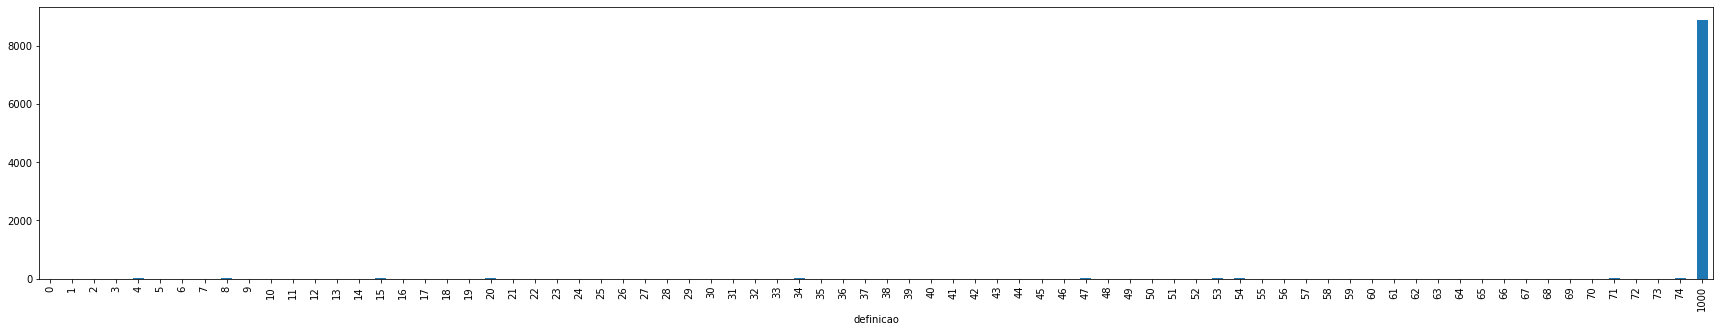

In [ ]:
fig = plt.figure(figsize=(30,5))
df_val.groupby('definicao').definicao.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

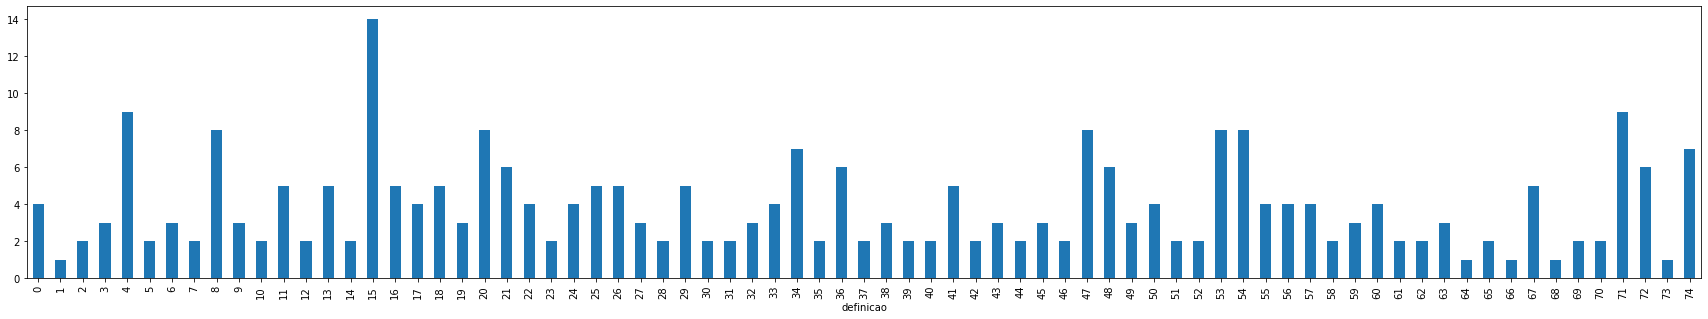

In [ ]:
fig = plt.figure(figsize=(30,5))
df_val[df_val['definicao']!=1000].groupby('definicao').definicao.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

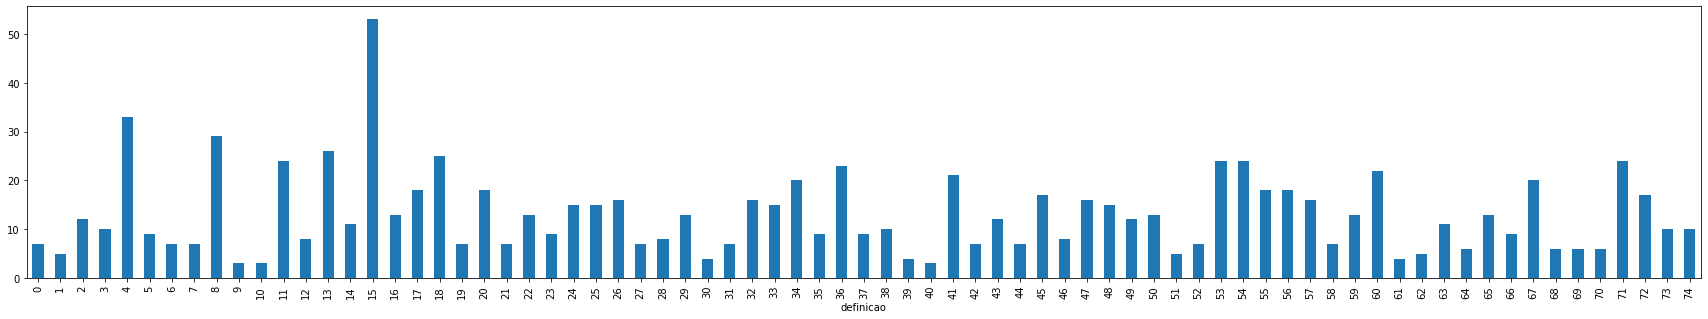

In [ ]:
fig = plt.figure(figsize=(30,5))
df_teste.groupby('definicao').definicao.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

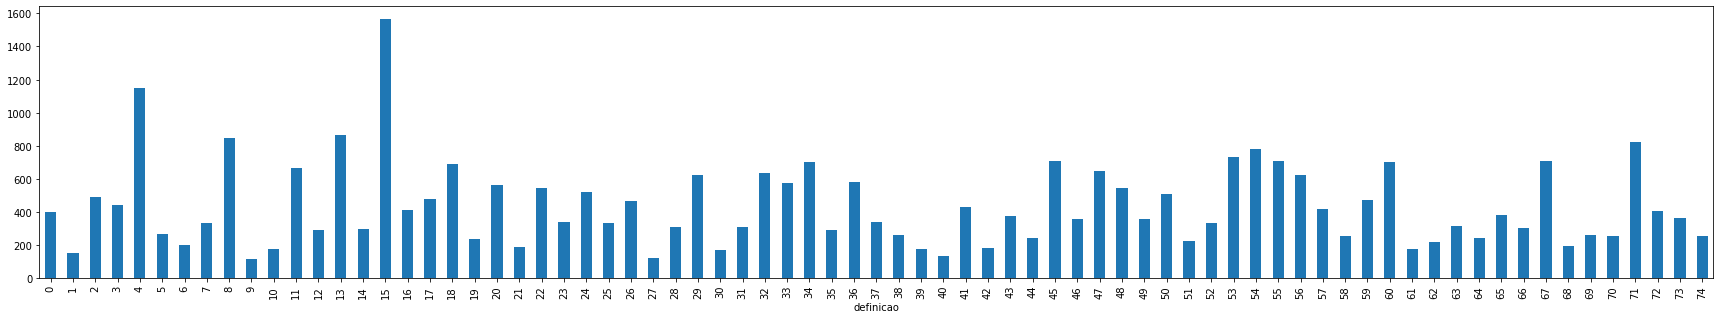

In [ ]:
fig = plt.figure(figsize=(30,5))
df_treino.groupby('definicao').definicao.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

In [ ]:
grava(df_test, path_modelos+'df_test.pkl')
grava(df_val, path_modelos+'df_val.pkl')
grava(df_treino, path_modelos+'df_treino.pkl')
grava(df_teste, path_modelos+'df_teste.pkl')

## Limpeza

In [ ]:
'''df_produto = pd.read_csv('produtos.csv')
df_produto['definicao'] = np.NaN
df_produto['ncm'] = df_produto.ncm.astype(str)
df_produto['ncm'] = df_produto['ncm'].apply(lambda x: ''.join(['0',x]) if len(x) == 7 else x)
df_produto['Produto'] = df_produto['xprod']
df_produto['ucom'] = df_produto['ucom'].replace('^\s*$|^$', 'und', regex=True)
df_produto.loc[df_produto.ucom.isin(lista_lt), 'ucom'] = 'lt'
df_produto.loc[df_produto.ucom.isin(lista_kg), 'ucom'] = 'kg'
df_produto.loc[df_produto.ucom.isin(lista_und), 'ucom'] = 'und'
df_produto.locdf = limpa_descricoes(df, 'xprod')[df_produto.ucom.isin(lista_pct), 'ucom'] = 'pct'
df_produto.loc[df_produto.ucom.isin(lista_cx), 'ucom'] = 'cx'
df_produto.loc[df_produto.ucom.isin(lista_frd), 'ucom'] = 'frd'
df_produto.loc[df_produto.ucom.isin(lista_sc), 'ucom'] = 'sc'
df_produto.loc[~df_produto.ucom.isin(unidades), 'ucom'] = 'und' '''

"df_produto = pd.read_csv('produtos.csv')\ndf_produto['definicao'] = np.NaN\ndf_produto['ncm'] = df_produto.ncm.astype(str)\ndf_produto['ncm'] = df_produto['ncm'].apply(lambda x: ''.join(['0',x]) if len(x) == 7 else x)\ndf_produto['Produto'] = df_produto['xprod']\ndf_produto['ucom'] = df_produto['ucom'].replace('^\\s*$|^$', 'und', regex=True)\ndf_produto.loc[df_produto.ucom.isin(lista_lt), 'ucom'] = 'lt'\ndf_produto.loc[df_produto.ucom.isin(lista_kg), 'ucom'] = 'kg'\ndf_produto.loc[df_produto.ucom.isin(lista_und), 'ucom'] = 'und'\ndf_produto.locdf = limpa_descricoes(df, 'xprod')[df_produto.ucom.isin(lista_pct), 'ucom'] = 'pct'\ndf_produto.loc[df_produto.ucom.isin(lista_cx), 'ucom'] = 'cx'\ndf_produto.loc[df_produto.ucom.isin(lista_frd), 'ucom'] = 'frd'\ndf_produto.loc[df_produto.ucom.isin(lista_sc), 'ucom'] = 'sc'\ndf_produto.loc[~df_produto.ucom.isin(unidades), 'ucom'] = 'und' "

## Preprocessing

In [ ]:
'''df_treino = abre(path_modelos+f'df_treino.pkl')
df_teste = abre(path_modelos+f'df_teste.pkl')
df_val = abre(path_modelos+f'df_val.pkl')'''

df_treino = pre_processing_pln(df_treino, 'xprod')
df_teste = pre_processing_pln(df_teste, 'xprod')
df_val = pre_processing_pln(df_val, 'xprod')
df_val_sem_ruido = df_val[df_val['definicao']!=1000]

###Unique values 

In [ ]:
'''todas_classes = df['definicao'].unique().tolist()
for classe in sorted(todas_classes):
  descr_unicas = df[df['definicao'] == classe]['xprod'].unique().tolist()
  if descr_unicas:
    print(descr_unicas)'''

"todas_classes = df['definicao'].unique().tolist()\nfor classe in sorted(todas_classes):\n  descr_unicas = df[df['definicao'] == classe]['xprod'].unique().tolist()\n  if descr_unicas:\n    print(descr_unicas)"

### Dividindo em teste e treino

In [ ]:
X_train, X_test, y_train, y_test = df_treino['xprod'], df_teste['xprod'], df_treino['definicao'], df_teste['definicao']

### Codificando xprod

#### tf-idf

In [ ]:
count_vect = CountVectorizer(ngram_range=(2,4), min_df=2) 
tfidf_transformer = TfidfTransformer()

In [ ]:
X_train_counts = count_vect.fit_transform(X_train)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

X_val_counts = count_vect.transform(df_val_sem_ruido['xprod'])
X_val_tfidf = tfidf_transformer.transform(X_val_counts)

y_val = df_val_sem_ruido['definicao'].astype(int).tolist()

X_val_counts_ruido = count_vect.transform(df_val['xprod'])
X_val_tfidf_ruido = tfidf_transformer.transform(X_val_counts_ruido)

y_val_ruido = df_val['definicao'].astype(int).tolist()

#### oversample

In [ ]:
rus = RandomOverSampler()
X_train_tfidf, y_train = rus.fit_sample(X_train_tfidf, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
grava(X_train_tfidf, path_modelos+'X_train_tfidf.pkl')
grava(X_test_tfidf, path_modelos+'X_test_tfidf.pkl')

grava(y_train, path_modelos+'y_train.pkl')
grava(y_test, path_modelos+'y_test.pkl')

grava(X_val_tfidf, path_modelos+'X_val_tfidf.pkl')
grava(y_val, path_modelos+'y_val.pkl')

grava(X_val_tfidf_ruido, path_modelos+'X_val_tfidf_ruido.pkl')
grava(y_val_ruido, path_modelos+'y_val_ruido.pkl')

#### word2vec


In [ ]:
'''qtd_palavras = 20
qtd_dimensoes = 300
qtd_dimensoes_umap = 20 '''

'qtd_palavras = 20\nqtd_dimensoes = 300\nqtd_dimensoes_umap = 20 '

In [ ]:
'''counts = df['definicao'].value_counts()
df = df[df['definicao'].isin(counts[counts > 2].index)]
sentences = [descr.split()[:qtd_palavras] for descr in df['xprod']]
#sentences_teste = [descr.split()[:qtd_palavras] for descr in df_aux['xprod']]
#vocab_sem_repetidos = [list(item) for item in set(tuple(row) for row in sentences+sentences_teste)]

#model = Word2Vec(vocab_sem_repetidos,size=qtd_dimensoes, min_count=1, workers=-1)
# model.wv[]
doc_vectors = {}

for number, sent in enumerate(sentences):
    #agora dando peso maior pras primeiras palavras, peso decrescente ateh o final, numeros com mesmo peso da primeira palavra:
    if len(sent) == 0:
        doc_vectors[number] = np.zeros(qtd_dimensoes,)
    elif len(sent) == 1:
        doc_vectors[number] = ft.get_word_vector(sent[0])
    elif len(sent) > 1:
        pesos = np.array(range(len(sent))[::]) + 1
        pesos = 1 / pesos
        media = []
        divisao = 0
        counter = 0
        for word in sent:
            # peso dobrado pra digits
            if word.isdigit():
                media.append(ft.get_word_vector(word) * ((pesos[0]+pesos[-1])*(1/2)) )
                divisao += ((pesos[0]+pesos[-1])*(1/2))
            else:
                media.append(ft.get_word_vector(word) * pesos[counter])
                divisao += pesos[counter]
            counter += 1
        doc_vectors[number] = np.array(media).sum(axis=0) / divisao #media de tudo'''

"counts = df['definicao'].value_counts()\ndf = df[df['definicao'].isin(counts[counts > 2].index)]\nsentences = [descr.split()[:qtd_palavras] for descr in df['xprod']]\n#sentences_teste = [descr.split()[:qtd_palavras] for descr in df_aux['xprod']]\n#vocab_sem_repetidos = [list(item) for item in set(tuple(row) for row in sentences+sentences_teste)]\n\n#model = Word2Vec(vocab_sem_repetidos,size=qtd_dimensoes, min_count=1, workers=-1)\n# model.wv[]\ndoc_vectors = {}\n\nfor number, sent in enumerate(sentences):\n    #agora dando peso maior pras primeiras palavras, peso decrescente ateh o final, numeros com mesmo peso da primeira palavra:\n    if len(sent) == 0:\n        doc_vectors[number] = np.zeros(qtd_dimensoes,)\n    elif len(sent) == 1:\n        doc_vectors[number] = ft.get_word_vector(sent[0])\n    elif len(sent) > 1:\n        pesos = np.array(range(len(sent))[::]) + 1\n        pesos = 1 / pesos\n        media = []\n        divisao = 0\n        counter = 0\n        for word in sent:\n

In [ ]:
'''doc_vectors = pd.DataFrame(doc_vectors).T
doc_vectors = doc_vectors.set_index(df.index) 

scaler = StandardScaler()
doc_vectors_std_df = pd.DataFrame(scaler.fit_transform(doc_vectors),index=doc_vectors.index,columns=doc_vectors.columns)'''

'doc_vectors = pd.DataFrame(doc_vectors).T\ndoc_vectors = doc_vectors.set_index(df.index) \n\nscaler = StandardScaler()\ndoc_vectors_std_df = pd.DataFrame(scaler.fit_transform(doc_vectors),index=doc_vectors.index,columns=doc_vectors.columns)'

In [ ]:
'''umap_redux = umap.UMAP(n_components=qtd_dimensoes_umap, random_state=999, metric='cosine',verbose=True)
umap_redux.fit(doc_vectors_std_df)
doc_vectors_std_df_umap = umap_redux.transform(X=doc_vectors_std_df)
'''
#df['avg_vec'] = pd.DataFrame(doc_vectors_std_df_umap).values.mean(axis=1)

"umap_redux = umap.UMAP(n_components=qtd_dimensoes_umap, random_state=999, metric='cosine',verbose=True)\numap_redux.fit(doc_vectors_std_df)\ndoc_vectors_std_df_umap = umap_redux.transform(X=doc_vectors_std_df)\n"

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(pd.DataFrame(doc_vectors_std_df_umap), df['definicao'], test_size=0.2, stratify=df['definicao'], random_state=0)

## Treinamento

In [ ]:
X_train_tfidf = abre(path_modelos+'X_train_tfidf.pkl')
X_test_tfidf = abre(path_modelos+'X_test_tfidf.pkl')
y_train = abre(path_modelos+'y_train.pkl')
y_test = abre(path_modelos+'y_test.pkl')
X_val_tfidf = abre(path_modelos+'X_val_tfidf.pkl')
y_val = abre(path_modelos+'y_val.pkl')
X_val_tfidf_ruido = abre(path_modelos+'X_val_tfidf_ruido.pkl')
y_val_ruido = abre(path_modelos+'y_val_ruido.pkl')
df_val = abre(path_modelos+'df_val.pkl')
df_val_sem_ruido = df_val[df_val['definicao']!=1000]

### modelos

In [ ]:
model = RandomForestClassifier(n_estimators=100)
   
kf = StratifiedKFold(n_splits=5, shuffle=True)
#kf.get_n_splits(X_train_tfidf)
for train_index, test_index in kf.split(X_train_tfidf, y_train):
    X_train, _ = X_train_tfidf[train_index], X_train_tfidf[test_index]
    Y_train, _ = y_train[train_index], y_train[test_index] #sem oversample usa iloc[test_index]
    clf = model.fit(X_train, Y_train)
y_pred = clf.predict(X_test_tfidf)
#print(f'Acurácia teste: {accuracy_score(y_test, y_pred)}')
print(f'F1: {f1_score(y_test, y_pred, average='macro')}')

In [ ]:
grava(clf, path_modelos2+f'(f1:{f1_score(y_test, y_pred, average='macro'):.2f}).pkl')

### Comitês

##### Stack

###### Cross-val

In [ ]:
df = abre(path_tcc+'df_ptreinos.pkl')
df = pre_processing_pln(df, 'xprod')
df = df.drop_duplicates(subset='xprod').reset_index(drop=True)
X_train, y_train = df['xprod'], df['definicao']
count_vect = CountVectorizer(ngram_range=(2,4), min_df=2) # 15000 para 300
tfidf_transformer = TfidfTransformer()

X_train_counts = count_vect.fit_transform(X_train)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#rus = RandomOverSampler()
#X_train_tfidf, y_train = rus.fit_sample(X_train_tfidf, y_train)

In [ ]:
def get_stacking():
  # define the base models
  level0 = list()
  level0.append(('lr', LogisticRegression()))
  level0.append(('lr2', LogisticRegression(solver='liblinear')))
  level0.append(('tree', DecisionTreeClassifier()))
  level0.append(('tree2', DecisionTreeClassifier(criterion='entropy')))
  level0.append(('knn', KNeighborsClassifier(n_neighbors=3, p=1)))
  level0.append(('knn2', KNeighborsClassifier(n_neighbors=3)))
  level0.append(('svm', make_pipeline(StandardScaler(with_mean=False), SVC(gamma='auto',probability=True))))
  level0.append(('svm2', make_pipeline(StandardScaler(with_mean=False), SVC(probability=True))))
  level0.append(('bayes', MultinomialNB()))
  level0.append(('bayes2', MultinomialNB(alpha=0.1)))
  level0.append(('mlp', MLPClassifier(hidden_layer_sizes=(15,15), random_state=1)))
  level0.append(('mlp2', MLPClassifier(hidden_layer_sizes=(25,25), random_state=1)))
  level1 = LogisticRegression()
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  return model

def get_models():
  models = dict()
  models['lr'] = LogisticRegression()
  models['lr2'] = LogisticRegression(solver='liblinear')
  models['tree'] = DecisionTreeClassifier()
  models['tree2'] = DecisionTreeClassifier(criterion='entropy')
  models['knn'] = KNeighborsClassifier(n_neighbors=3, p=1)
  models['knn2'] = KNeighborsClassifier(n_neighbors=3)
  models['svm'] = make_pipeline(StandardScaler(with_mean=False), SVC(gamma='auto',probability=True))
  models['svm2'] = make_pipeline(StandardScaler(with_mean=False), SVC(probability=True))
  models['bayes'] = MultinomialNB()
  models['bayes2'] = MultinomialNB(alpha=0.1)
  models['mlp'] = MLPClassifier(hidden_layer_sizes=(15,15), random_state=1)
  models['mlp2'] = MLPClassifier(hidden_layer_sizes=(25,25), random_state=1)
  models['stacking'] = get_stacking()
  return models

from sklearn.model_selection import RepeatedStratifiedKFold
def evaluate_model(model, X, y):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(model, X, y, scoring='f1_micro', cv=cv, n_jobs=-1, error_score='raise')
  return scores

In [ ]:
from numpy import mean
from numpy import std
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
models = get_models()
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model, X_train_tfidf, y_train)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

##### Fit

In [ ]:
clfs = [('nb', MultinomialNB()),\
         ('lr', LogisticRegression()),\
         ('tree', DecisionTreeClassifier()),\
         ('svm', make_pipeline(StandardScaler(with_mean=False), SVC(probability=True))),\
         ('mlp', MLPClassifier(hidden_layer_sizes=(20,20), random_state=1, verbose=True))]

In [ ]:
stacking = StackingClassifier(estimators = clfs, final_estimator = LogisticRegression(), stack_method='predict_proba')
stacking.fit(X_train_tfidf, y_train).score(X_test_tfidf, y_test)
y_pred=stacking.predict(X_test_tfidf)
grava(stacking, path_modelos2+f"stack4(f1:{f1_score(y_test, y_pred, average='macro'):.5f}).pkl")

##### Bagging

In [ ]:
clf = BaggingClassifier(base_estimator=MLPClassifier(hidden_layer_sizes=(40,20)),n_estimators=10, oob_score=True, random_state=0).fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
grava(clf, path_modelos2+'bagg.pkl')
print(f"f1: {f1_score(y_test, y_pred, average='macro')}")
accuracy_score(y_test, y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


f1: 0.8906485261446068


0.9020408163265307

##### Super learner

In [ ]:
def get_out_of_fold_predictions(X, y, models):
  meta_X, meta_y = list(), list()
  kf = StratifiedKFold(n_splits=5, shuffle=True)
  for train_ix, test_ix in kf.split(X_train_tfidf, y_train):
    fold_yhats = list()
    train_X, test_X = X[train_ix], X[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]
    meta_y.extend(test_y)
    for model in models:
      #model.fit(train_X, train_y)
      yhat = model.predict_proba(test_X)
      fold_yhats.append(yhat)
    meta_X.append(hstack(fold_yhats))
  return vstack(meta_X), asarray(meta_y)

def get_models():
  models = list()
  models.append(BaggingClassifier(base_estimator=MLPClassifier(hidden_layer_sizes=(40,20)),n_estimators=10, oob_score=True, random_state=0).fit(X_train_tfidf, y_train))

  return models

def fit_base_models(X, y, models):
	for model in models:
		model.fit(X, y)
 
def fit_meta_model(X, y):
	model = LogisticRegression()
	model.fit(X, y)
	return model
 
def evaluate_models(X, y, models):
	for model in models:
		yhat = model.predict(X)
		acc = accuracy_score(y, yhat)
		print('%s: %.2f' % (model.__class__.__name__, acc*100))
 
def super_learner_predictions(X, models, meta_model):
	meta_X = list()
	for model in models:
		yhat = model.predict_proba(X)
		meta_X.append(yhat)
	meta_X = hstack(meta_X)
	return meta_model.predict(meta_X)

In [ ]:
models = get_models()
meta_X, meta_y = get_out_of_fold_predictions(X_train_tfidf, y_train, models)
fit_base_models(X_train_tfidf, y_train, models)
meta_model = fit_meta_model(meta_X, meta_y)
evaluate_models(X_test_tfidf, y_test, models)

yhat = super_learner_predictions(X_test_tfidf, models, meta_model)
print('Super Learner: %.2f' % (accuracy_score(y_test, yhat) * 100))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


BaggingClassifier: 91.35
Super Learner: 91.35


In [ ]:
grava(meta_model, path_modelos2+"meta_super_model.pkl")
grava(models, path_modelos2+"models_super_model.pkl")

##### Votação

In [ ]:
# votação sklearn https://stackoverflow.com/questions/42920148/using-sklearn-voting-ensemble-with-partial-fit
clfs = [nb, nb2, rf, rf2]
eclf = EnsembleVoteClassifier(clfs=clfs, voting="hard", refit=False)
eclf.fit(None,np.array(real_groups))

### Confusion Matrix

Text(0.5, 1.0, 'Accuracy:0.90')

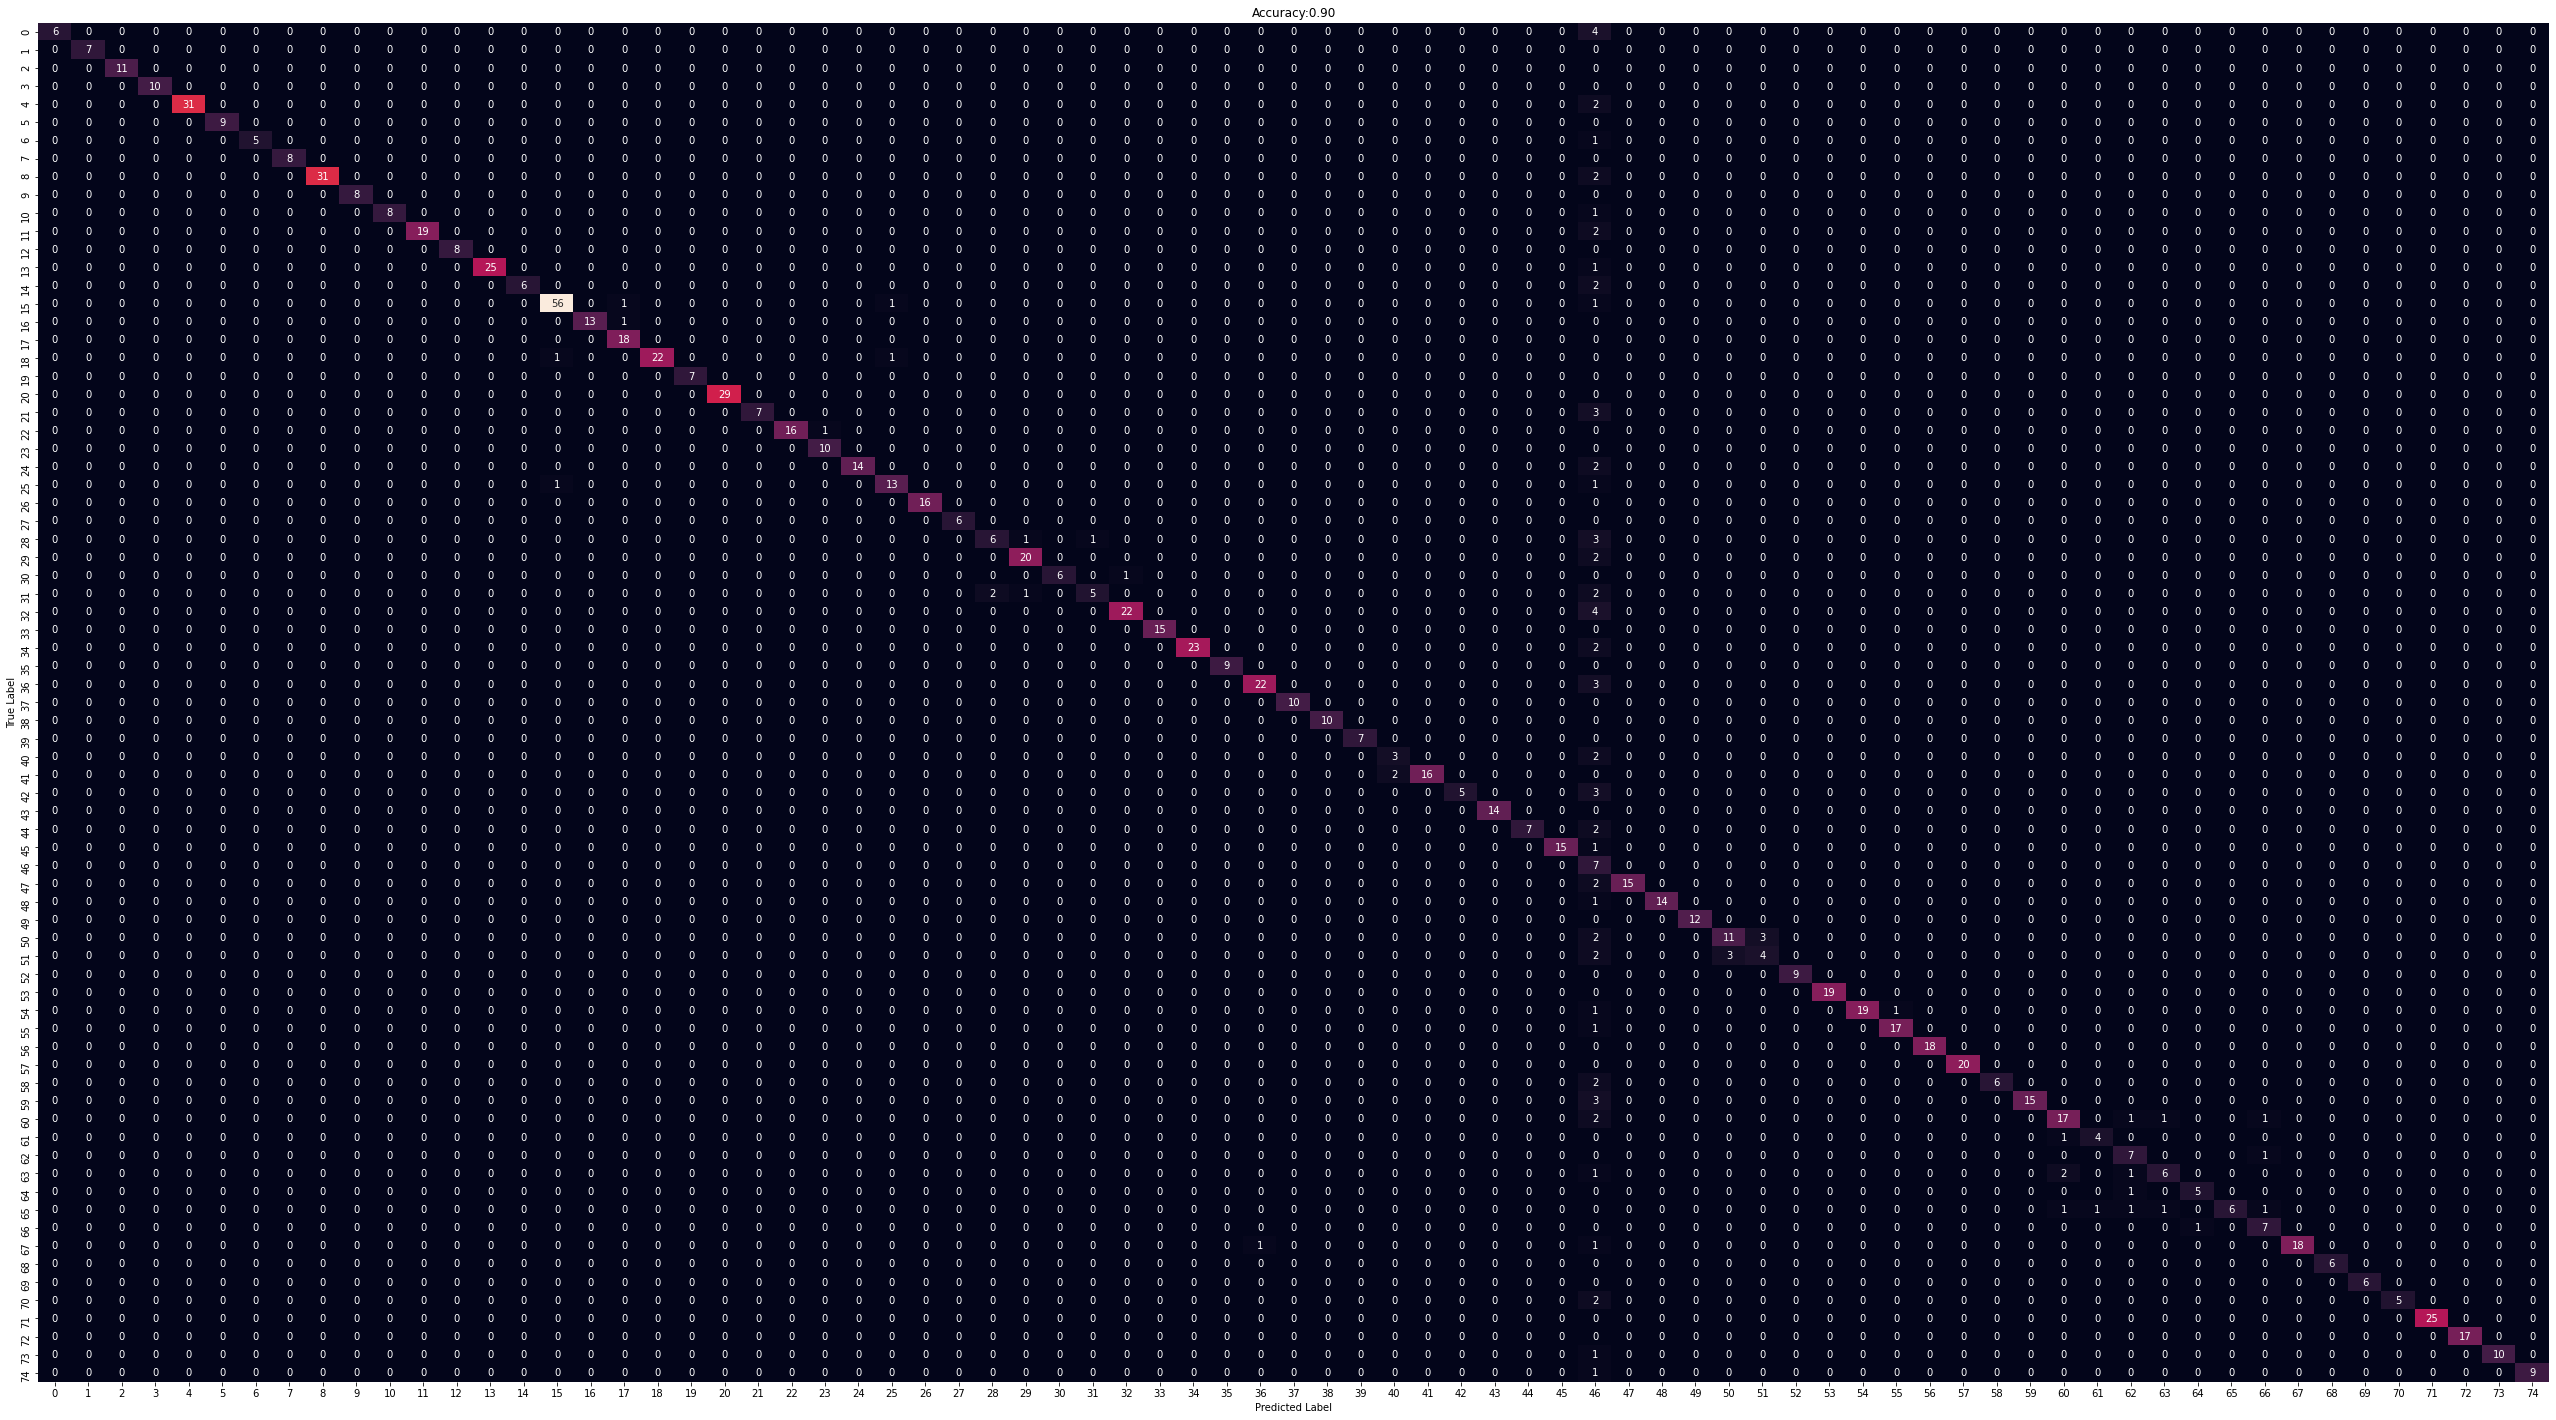

In [ ]:
classes = df_treino['definicao'].unique().tolist()
plt.figure(figsize=(45,25))
cm = confusion_matrix(y_test, y_pred)
#cm = confusion_matrix(y_test, yhat)
axes = sorted(classes)
sns.heatmap(cm, annot=True, cbar=False, fmt='g', xticklabels= axes, yticklabels=axes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Accuracy:{0:.2f}'.format(accuracy_score(y_test, y_pred)))

## Predição

In [ ]:
df_treino = abre(path_modelos+'df_treino.pkl')
df_teste = abre(path_modelos+'df_teste.pkl')
df_val = abre(path_modelos+'df_val.pkl')
X_train_tfidf = abre(path_modelos+'X_train_tfidf.pkl')
X_test_tfidf = abre(path_modelos+'X_test_tfidf.pkl')
y_train = abre(path_modelos+'y_train.pkl')
y_test = abre(path_modelos+'y_test.pkl')
X_val_tfidf = abre(path_modelos+'X_val_tfidf.pkl')
y_val = abre(path_modelos+'y_val.pkl')
X_val_tfidf_ruido = abre(path_modelos+'X_val_tfidf_ruido.pkl')
y_val_ruido = abre(path_modelos+'y_val_ruido.pkl')
df_val = abre(path_modelos+'df_val.pkl')
df_val_sem_ruido = df_val[df_val['definicao']!=1000]

In [ ]:
# mapear numero dos grupos encoded com grupos preditos
real_groups = sorted(set(y_train))
dictionary = dict(zip(list(range(len(real_groups))), real_groups))

#### Stack

In [ ]:
stacking = abre(path_modelos+"stack.pkl")
y_prob = stacking.predict_proba(X_val_tfidf_ruido)
y_prob = [ dictionary[np.argmax(probs)] if max(probs) > 0.5 else 1000 for probs in y_prob ]
#accuracy_score(y_test.tolist(), y_prob)
accuracy_score(y_val_ruido, y_prob)

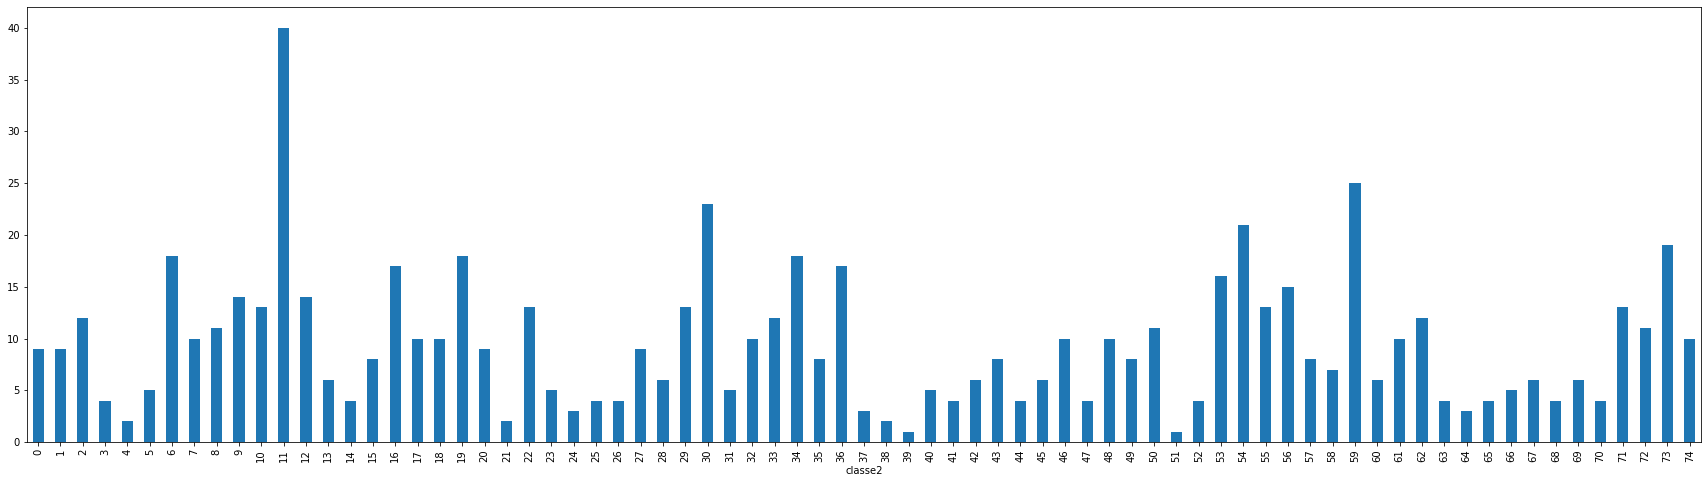

In [ ]:
'''df_teste['classe2'] = y_prob
fig = plt.figure(figsize=(30,8))
df_teste.groupby('classe2').classe.count().plot.bar(ylim=0)
#df_val[df_val['classe']!=1000].groupby('classe').classe.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()'''
df_val['classe2'] = y_prob
fig = plt.figure(figsize=(30,8))
df_val[df_val['classe2']!=1000].groupby('classe2').classe.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

In [ ]:
#n = 104
testando = df_val[df_val['classe2']==n]
print(len(testando))
testando['xprod'].unique()

#### Super-learner

https://machinelearningmastery.com/super-learner-ensemble-in-python/

In [ ]:
def super_learner_predictions(X, models, meta_model):
	meta_X = list()
	for model in models:
		yhat = model.predict_proba(X)
		meta_X.append(yhat)
	meta_X = hstack(meta_X)
 
	return meta_model.predict_proba(meta_X)

In [ ]:
models = abre (path_modelos2+"models_super_model.pkl")
meta_model = abre(path_modelos2+"meta_super_model.pkl")

y_prob = super_learner_predictions(X_test_tfidf, models, meta_model)
y_prob = [ dictionary[np.argmax(probs)] if max(probs) > 0.5 else 1000 for probs in y_prob ]
accuracy_score(y_test.tolist(), y_prob)

0.9020172910662824

In [ ]:
df_teste['classe'] = y_prob
fig = plt.figure(figsize=(30,8))
df_teste.groupby('classe').classe.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

In [ ]:
n = 14
testando = df_teste[df_teste['classe']==n]
testando['Produto'].unique()

In [ ]:
#models = abre (path_modelos+"models_super_model.pkl")
#meta_model = abre(path_modelos+"meta_super_model.pkl")

y_prob = super_learner_predictions(X_val_tfidf_ruido, models, meta_model)
y_prob = [ dictionary[np.argmax(probs)] if max(probs) > 0.5 else 1000 for probs in y_prob ]
df_val['classe'] = y_prob
accuracy_score(y_val_ruido, y_prob)

0.9762292412894823

In [ ]:
fig = plt.figure(figsize=(30,8))
df_val[df_val['classe']!=1000].groupby('classe').classe.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

In [ ]:
n = 6
testando2 = df_val[df_val['classe']==n]
print(len(testando2['Produto'].unique()))
testando2['Produto'].unique()

4


array(['açucar refinado marca ecoçucar',
       'acucar ref estrela 1kg granulado', 'acucar refinado estrela 1kg',
       'açucar refinado puro mel embalagem c/ 1kg'], dtype=object)

In [ ]:
testando2['xprod'].unique()

In [ ]:
#df_treino[df_treino['Produto'].str.contains('preto')].iloc[np.random.randint(len(df_treino[df_treino['Produto'].str.contains('preto')]),size=50)]
t = df_treino[df_treino['definicao']==n]
t.iloc[np.random.randint(len(t),size=50)]

#### Bagging

In [ ]:
bagg = abre(path_modelos2+"bagg.pkl")
y_prob = bagg.predict_proba(X_val_tfidf_ruido)
y_prob = [ dictionary[np.argmax(probs)] if max(probs) > 0.5 else 1000 for probs in y_prob ]
df_val['classe2'] = y_prob
#accuracy_score(y_test.tolist(), y_prob)
accuracy_score(y_val_ruido, y_prob)

0.9788648000871555

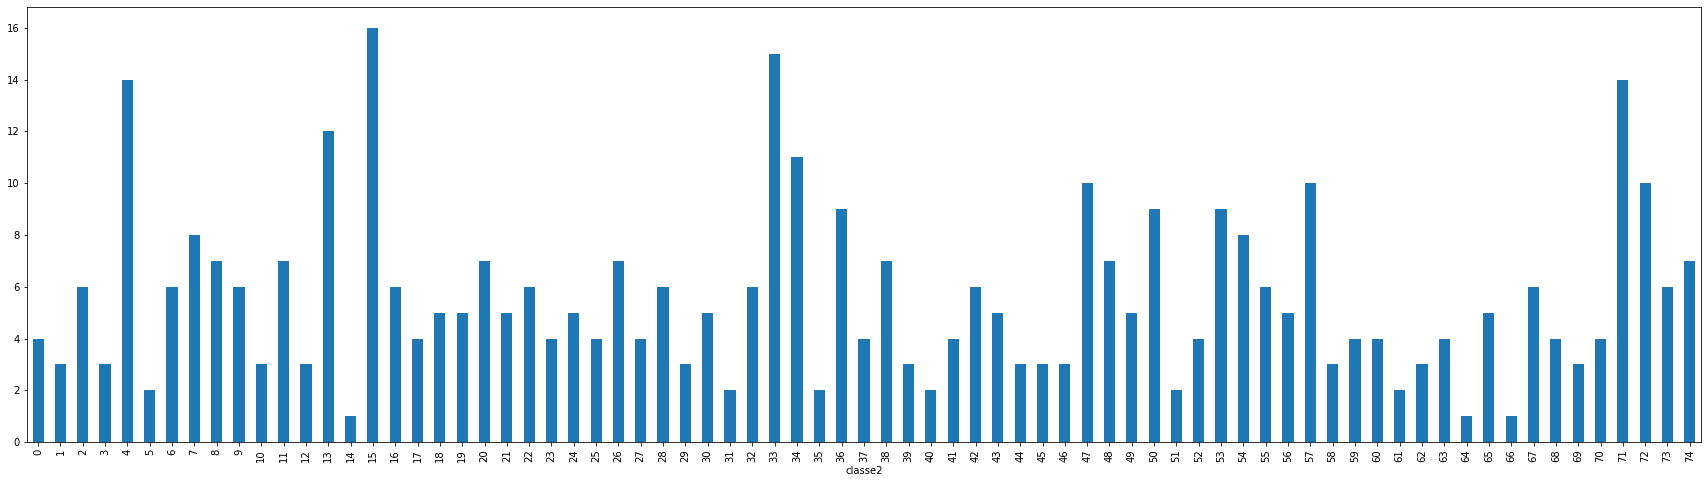

In [ ]:
fig = plt.figure(figsize=(30,8))
df_val[df_val['classe2']!=1000].groupby('classe2').classe2.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

In [ ]:
n = 69
testando3 = df_val[df_val['classe2']==n]
testando3['Produto'].unique()

array(['tijolo ceramica 19 x 19 x 09 cm 1a - assu',
       'tijo de ceramica 8 furos', 'tijolo de ceramica 8 furos'],
      dtype=object)

In [ ]:
testando3['xprod'].unique()

In [ ]:
t2 = df_treino[df_treino['definicao']==n]
t2.iloc[np.random.randint(len(t2),size=50)]
t2[t2['Produto'].str.contains(r'60')]

#### Votação Hard

In [ ]:
y_prob = clf.predict_proba(X_test_tfidf)
y_prob = [ dictionary[np.argmax(probs)] if max(probs) > 0.5 else 1000 for probs in y_prob ]
accuracy_score(y_test.tolist(), y_prob)

0.8514851485148515

In [ ]:
y_prob = clf.predict_proba(X_val_tfidf)

df_val_sem_ruido['classe'] = [ dictionary[np.argmax(probs)] if max(probs) > 0.5 else 1000 for probs in y_prob ]
#df_val_sem_ruido['classe'] = df_val_sem_ruido['classe'].apply(lambda x: int(x) if not pd.isna(x) else 1000)
df_val_sem_ruido['definicao'] = df_val_sem_ruido['definicao'].apply(lambda x: int(x))
print('Accuracia:{0:.2f}\n'.format(accuracy_score(df_val_sem_ruido['definicao'], df_val_sem_ruido['classe'])))

In [ ]:
plt.figure(figsize=(45,25))
cm = confusion_matrix(df_val_sem_ruido['definicao'], df_val_sem_ruido['classe'])
sns.heatmap(cm, annot=True, cbar=False, fmt='g', xticklabels = real_groups, yticklabels = real_groups)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Accuracy:{0:.2f}'.format(accuracy_score(df_val_sem_ruido['definicao'], df_val_sem_ruido['classe'])))

### outros

In [ ]:
#y_prob = clf.predict_proba(doc_vectors_std_umap_teste)
y_prob = clf.predict_proba(X_test_tfidf_others)
y_pred_prob = [ dictionary[np.argmax(probs)] if max(probs) > 0.90 else None for probs in y_prob ]
df_test['classe'] = y_pred_prob
qtd=df_test[~df_test['classe'].isna()]
print(f'Novas amostras detectadas: {len( qtd )}')

Novas amostras detectadas: 21673


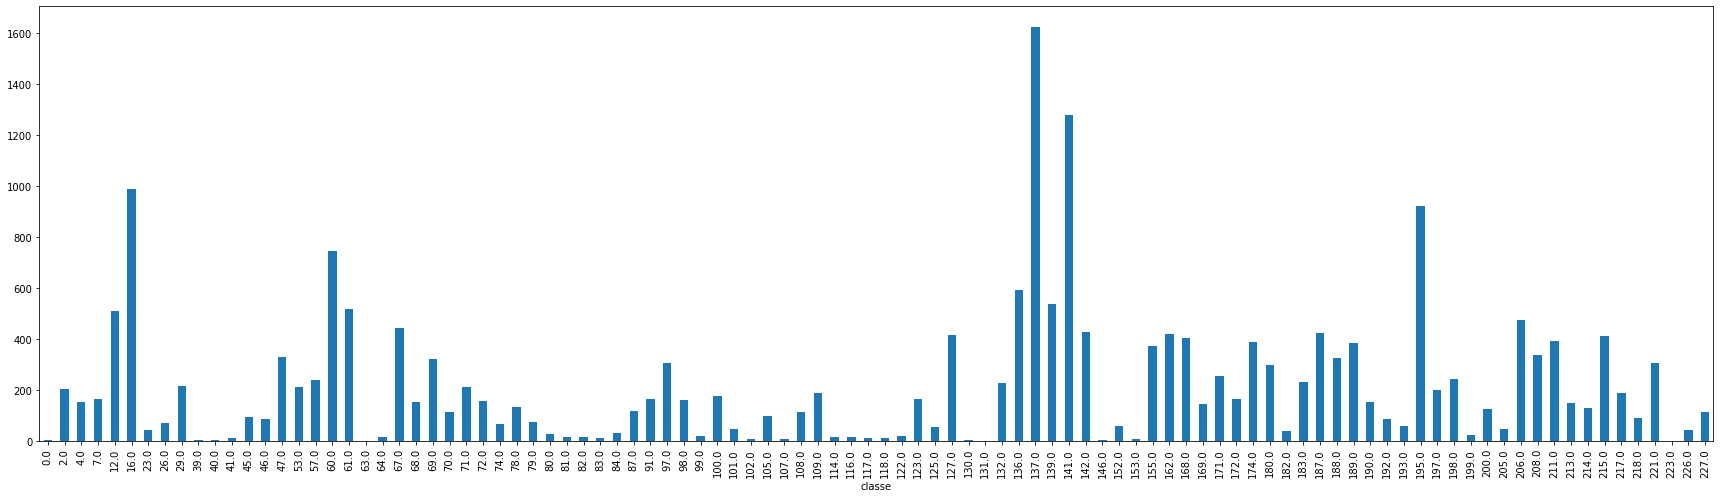

In [ ]:
fig = plt.figure(figsize=(30,8))
df_test.groupby('classe').classe.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

In [ ]:
n = 67
testando = df_test[df_test['classe']==n]
testando['Produto'].unique()

array(['bolacha cream cracker 400g', 'biscoito cream craker integral',
       'cream cracker 400g', 'biscoito salgado cream creacker 400g',
       'biscoito salgado cream cracker pct 400g',
       'biscoito cream cream craker', 'biscoito cream cream craker cx',
       'biscoito cream cracker integral 400g', 'cream cracker integral',
       'biscoito cream craker 400grs pct estrela',
       'biscoito sal c cracker estrela 400gr',
       'biscoito salgado integral 400g estrela', 'biscoito cream cracker',
       'biscoito salgado ceram cracker estrela',
       'biscoito cream craker estrela 400gr',
       'biscoito salgado 400g estrela',
       'biscoito salgado integral 400g vitabono',
       'biscoito cream craker 400g',
       'biscoito salgado cream craker integral 400g estrela',
       'biscoito cream cracker 400g marilan',
       'biscoito salgado integral 400g',
       'biscoito salgado cream craker 400grs pct estrela',
       'biscoito cream cracker integral 400g estrela',
       

In [ ]:
df_original[df_original['definicao']==n][:30][['Produto','xprod']] 

In [ ]:
#df_aux[~df_aux['classe'].isna()].iloc[np.random.randint(len(df_aux[~df_aux['classe'].isna()]),size=15)][['Produto','classe']]
#df[df['definicao']==53]['xprod'].unique().tolist()

In [ ]:
'''
n1 = 53
n2 = 5
#df_aux[df_aux['xprod'].str.contains('oleo deisel')][:50]
lista_teste= df[df['definicao']==n1]['xprod'].unique().tolist() + df[df['definicao']==n2]['xprod'].unique().tolist()
vocab = [word for descr in lista_teste for word in descr.split()]
dict1 = [word for descr in df[df['definicao']==n1]['xprod'].unique().tolist() for word in descr.split()]
dict2 = [word for descr in df[df['definicao']==n2]['xprod'].unique().tolist() for word in descr.split()]
resu= [word for word in set(vocab) if word in dict2 and word in dict1]
resu'''

### word2vec

In [ ]:
'''qtd_palavras = 10
qtd_dimensoes = 300
qtd_dimensoes_umap = 10
# map index do valor predito com a classe real 
pickle_off = open ("real_groups.pkl", "rb")
real_groups = pickle.load(pickle_off)
dictionary = dict(zip(list(range(len(real_groups))), real_groups))'''

In [ ]:
'''pickle_off = open ("produtos_test1.pkl", "rb")
df_aux = pickle.load(pickle_off)
sentences_teste = [descr.split()[:qtd_palavras] for descr in df_aux['xprod']]
doc_vectors_teste = {}
for number, sent in enumerate(sentences_teste):
    #agora dando peso maior pras primeiras palavras, peso decrescente ateh o final, numeros com mesmo peso da primeira palavra:
    if len(sent) == 0:
        doc_vectors_teste[number] = np.zeros(qtd_dimensoes,)
    elif len(sent) == 1:
        doc_vectors_teste[number] = ft.get_word_vector(sent[0])
    elif len(sent) > 1:
        pesos = np.array(range(len(sent))[::]) + 1
        pesos = 1 / pesos
        media = []
        divisao = 0
        counter = 0
        for word in sent:
            if word.isdigit():
                media.append(ft.get_word_vector(word) * ((pesos[0]+pesos[-1])*(1/2)) )
                divisao += ((pesos[0]+pesos[-1])*(1/2))
            else:
                media.append(ft.get_word_vector(word) * pesos[counter])
                divisao += pesos[counter]
            counter += 1
        doc_vectors_teste[number] = np.array(media).sum(axis=0) / divisao #media de tudo'''

In [ ]:
'''doc_vectors_teste = pd.DataFrame(doc_vectors_teste).T
doc_vectors_teste = doc_vectors_teste.set_index(df_aux.index) 

scaler = StandardScaler()
doc_vectors_std_df_teste = pd.DataFrame(scaler.fit_transform(doc_vectors_teste),index=doc_vectors_teste.index,columns=doc_vectors_teste.columns)'''

In [ ]:
'''umap_redux = umap.UMAP(n_components=qtd_dimensoes_umap, random_state=999, metric='cosine',verbose=True)
umap_redux.fit(doc_vectors_std_df_teste)
doc_vectors_std_df_umap_teste = umap_redux.transform(X=doc_vectors_std_df_teste)'''

In [ ]:
#pickle_off = open ("modelo.pkl", "rb")
#clf = pickle.load(pickle_off)

## Salva Resu

### absorve outros

In [ ]:
df_original['classe'] = df_original['definicao']
#df_aux = df_aux[~df_aux['classe'].isna()]
df_final = pd.concat([df_original, df_aux])

In [ ]:
fig = plt.figure(figsize=(20,5))
df_final.groupby('classe').definicao.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

### outros save

#### save

In [ ]:
'''df = df_produto[~df_produto['definicao'].isin(['outros'])] 

le = LabelEncoder()
df['classe'] = le.transform(df.definicao)
descricoes = le.classes_
grupos = le.transform(le.classes_)
'''

In [ ]:
calc_preco(df_final, grupos, descricoes)
df_final = df_final.round(2)
df_final['qcom'] = df_final['qcom'].astype(int)
df_final['vuncom'] = df_final['vuncom'].astype(str).str.replace('.',",")  
df_final['vprod'] = df_final['vprod'].astype(str).str.replace('.',",")
df_final = reindex_grupos(df_final)
df_final.to_csv('produtos_classificados.csv', encoding="utf-8-sig")

In [ ]:
'''
#mesclando classes preditas com determinadas
df_teste = pd.DataFrame(y_test)
df_train = pd.DataFrame(y_train)
#y_pred n preserva index, tem q pegar do teste (sobrescreve teste)
df_teste['definicao'] = y_pred.tolist()

df['classe'] = pd.concat([df_teste, df_train])

#df_out['classe'] = df_out['definicao']
#df = pd.concat([df, df_out])
'''